In [109]:
# Allow src folder to be imported from this notebook
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [110]:
import numpy as np
from collections import defaultdict
from src.blocks import Block
from typing import Union
from pathlib import Path
from Bio import AlignIO
from itertools import cycle
from PIL import Image

COLORS = [
    (255,0,0), # red
    (0,255,0), # green 
    (0,0,255), # blue
    (255,255,0), # yellow
    (0,255,255), # cyan
    (255,0,255), # magenta
    (255,125,0), # orange
    (125,0,255), # blue-magenta
    (255,0,125), # red-magenta
]

class InputBlockSet:

    def __call__(self, path_msa: Union[str,Path], blocks: list[Block]):
        
        msa, n_seqs, n_cols = self.load_msa(path_msa)
        coverage_panel = self.get_coverage_panel(n_seqs, n_cols, blocks)
        missing_blocks = self.get_missing_blocks(coverage_panel, msa)
        blocks_one_char = self.get_blocks_one_char(msa, n_seqs, n_cols)
        # set B: input blocks (maximal blocks, the decompositions under intersection by pairs and blocks of one position in the MSA)
        set_B = blocks + blocks_one_char  #[block for block in missing_blocks if block.j-block.i+1 > 1]

        return set_B

    @staticmethod
    def get_coverage_panel(n_seqs, n_cols, blocks):
        """returns a matrix of size equal to msa (n_seq x n_cols) with 
        the number of blocks in the list_blocks that covers each position"""

        # coverage_by_pos = defaultdict(int)
        coverage_panel = np.zeros((n_seqs, n_cols))
        for block in blocks:
            for r in block.K:
                for c in range(block.i,block.j+1):
                    coverage_panel[r,c] += 1
        return coverage_panel

    def get_missing_blocks(self, coverage_panel, msa): 
        """return the missing blocks to cover the MSA
        all consecutives one character not covered positions are
        clustered in one block
        """
        rows, cols=np.where(coverage_panel == 0)
        missing_blocks = [(r,c) for r,c in zip(rows,cols)]
        # missing_blocks = get_missing_blocks(coverage_panel)
        missing_blocks = sorted(missing_blocks, key= lambda d: (d[0],d[1]))
        idx_missing_blocks_by_seq = defaultdict(list)
        for pos in missing_blocks: 
            idx_missing_blocks_by_seq[pos[0]].append(pos[1])

        # now split each row into separate sublist of (row,col)
        missing_blocks=[]
        for seq, cols in idx_missing_blocks_by_seq.items():
            consecutive_pos = self.get_list_consecutive_pos(cols)
            for pos in consecutive_pos: 
                label = str(msa[int(seq)].seq[pos[0]:pos[-1]+1])
                missing_blocks.append(
                    Block(K=(seq,), i=pos[0],j=pos[-1], label=label)
                )

        return missing_blocks

    @staticmethod
    def get_list_consecutive_pos(positions: list[int]):
        "given a list with positions, split it in sublists of consecutive numbers"
        sublists = []

        # Set up current list with first element of input
        curr = [positions[0]]

        # For each remaining element:
        for x in positions[1:]:
            # If the next element is not 1 greater than the last seen element
            if x - 1 != curr[-1]:
                # Append the list to the return variable and start a new list
                sublists.append(curr)
                curr = [x]
            # Otherwise, append the element to the current list.
            else:
                curr.append(x)
        sublists.append(curr)
        return sublists

    def get_blocks_one_char(self, msa, n_seqs, n_cols):
        "generate trivial blocks, one seq and one col"
        blocks_one_char = []
        for col in range(n_cols):
            seq_by_char = defaultdict(list)
            for row in range(n_seqs):
                seq_by_char[msa[row,col]].append(row)

            for c, K in seq_by_char.items():
                blocks_one_char.append(
                        Block(K=K, i=col, j=col, label=c)
                )

        return blocks_one_char

    def load_msa(self, path_msa):
        "return alignment, number of sequences and columns"
        # load MSA
        align=AlignIO.read(path_msa, "fasta")
        n_cols = align.get_alignment_length()
        n_seqs = len(align)

        return align, n_seqs, n_cols

    @staticmethod
    def array2img(array):
        "Array to PIL image"
        m, M = array.min(), array.max()
        # rescale to [0,1]
        img_rescaled = (array - m) / (M-m)
        
        # invert colors black->white
        img_array = np.ceil(255 - img_rescaled*255)
        dtype = eval(f"np.int8")
        img_array = np.array(img_array, dtype=dtype)
        
        # convert to Image 
        img_pil = Image.fromarray(img_array,'L')
        return img_pil

    def save_img(self, array, path_save):
        "Save image in grayscale for the FCGR provided as input"
        Path(path_save).parent.mkdir(exist_ok=True, parents=True)
        img_pil = self.array2img(array)
        img_pil.save(path_save)


    def get_coverage_color_panel(self, n_seqs, n_cols, blocks, colors):
        """returns a matrix of size equal to msa (n_seq x n_cols) with 
        the number of blocks in the list_blocks that covers each position"""
        colors = iter(cycle(colors))
        # coverage_by_pos = defaultdict(int)
        coverage_panel = np.zeros((n_seqs, n_cols,3))
        for block in blocks:
            color = next(colors)
            for r in block.K:
                for c in range(block.i,block.j+1):
                    coverage_panel[r,c,:] = color
        return coverage_panel

    def save_colored_img(self, array, path_save):
        img_pil = Image.fromarray(array.astype("uint8"),"RGB")
        img_pil.save(path_save)

In [112]:
name_msa = "Cluster_12313"
PATH_MSA=f"../msas/{name_msa}.fa"
PATH_BLOCKS=f"../subsample-experiment/block_decomposition/{name_msa}.json"
PATH_SAVE_COVERAGE = f"../subsample-experiment/msa-coverage/{name_msa}.jpeg"
import json
from src.blocks import Block
with open(PATH_BLOCKS, "r") as fp:
    blocks=json.load(fp)
blocks=[Block(*args) for args in blocks]
inputset=InputBlockSet()
set_B=inputset(path_msa=PATH_MSA, blocks=blocks)

In [116]:
set_B[30:45]

[Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=28, j=28, label='T'),
 Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=29, j=29, label='G'),
 Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=30, j=30, label='C'),
 Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=31, j=31, label='G'),
 Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8,

In [117]:
from PIL import Image
from Bio import AlignIO
import numpy as np 
from pathlib import Path
from itertools import cycle

COLORS = [
    (255,0,0), # red
    (0,255,0), # green 
    (0,0,255), # blue
    (255,255,0), # yellow
    (0,255,255), # cyan
    (255,0,255), # magenta
    (255,125,0), # orange
    (125,0,255), # blue-magenta
    (255,0,125), # red-magenta
]

class CoverageMSA:

    # def __call__(self, path_msa, blocks, path_save grayscale: bool=True, color: bool=False):
    #     msa, n_seqs, n_cols = self.load_msa(path_msa)
    #     coverage_gray = self.get_coverage_panel(n_seqs, n_cols, blocks)
    #     save_img = 

    def load_msa(self, path_msa):
        "return alignment, number of sequences and columns"
        # load MSA
        align=AlignIO.read(path_msa, "fasta")
        n_cols = align.get_alignment_length()
        n_seqs = len(align)

        return align, n_seqs, n_cols

    @staticmethod
    def array2img(array):
        "Array to PIL image"
        m, M = array.min(), array.max()
        # rescale to [0,1]
        img_rescaled = (array - m) / (M-m)
        
        # invert colors black->white
        img_array = np.ceil(255 - img_rescaled*255)
        dtype = eval(f"np.int8")
        img_array = np.array(img_array, dtype=dtype)
        
        # convert to Image 
        img_pil = Image.fromarray(img_array,'L')
        return img_pil

    def save_img(self, array, path_save):
        "Save image in grayscale for the FCGR provided as input"
        Path(path_save).parent.mkdir(exist_ok=True, parents=True)
        img_pil = self.array2img(array)
        img_pil.save(path_save)


    def save_colored_img(self, array, path_save):
        img_pil = Image.fromarray(array.astype("uint8"),"RGB")
        img_pil.save(path_save)

    @staticmethod
    def get_coverage_panel(n_seqs, n_cols, blocks):
        """returns a matrix of size equal to msa (n_seq x n_cols) with 
        the number of blocks in the list_blocks that covers each position"""

        # coverage_by_pos = defaultdict(int)
        coverage_panel = np.zeros((n_seqs, n_cols))
        for block in blocks:
            for r in block.K:
                for c in range(block.i,block.j+1):
                    coverage_panel[r,c] += 1
        return coverage_panel

    @staticmethod
    def get_coverage_color_panel( n_seqs, n_cols, blocks, colors=COLORS):
        """returns a matrix of size equal to msa (n_seq x n_cols) with 
        the number of blocks in the list_blocks that covers each position"""
        colors = iter(cycle(colors))
        # coverage_by_pos = defaultdict(int)
        coverage_panel = np.zeros((n_seqs, n_cols,3))
        for block in blocks:
            color = next(colors)
            for r in block.K:
                for c in range(block.i,block.j+1):
                    coverage_panel[r,c,:] = color
        return coverage_panel
        
    

In [122]:
cov_msa = CoverageMSA()
msa, n_seqs, n_cols = cov_msa.load_msa(PATH_MSA)
cov_panel = cov_msa.get_coverage_panel(n_seqs, n_cols, blocks)
cov_msa.save_img(cov_panel, path_save=f"../ilp-experiments/coverage-msa/{Path(PATH_MSA).stem}-gray.jpg")


In [124]:
color_cov_panel = cov_msa.get_coverage_color_panel(n_seqs, n_cols, blocks)
cov_msa.save_colored_img(color_cov_panel, path_save=f"../ilp-experiments/coverage-msa/{Path(PATH_MSA).stem}-color.jpg")

In [43]:
missing_blocks = inputset.get_missing_blocks(coverage_panel, msa)
missing_blocks

[Block(K=(0,), i=41, j=41, label='C'),
 Block(K=(1,), i=41, j=41, label='C'),
 Block(K=(2,), i=41, j=41, label='T'),
 Block(K=(3,), i=41, j=41, label='C'),
 Block(K=(4,), i=41, j=41, label='C'),
 Block(K=(5,), i=41, j=41, label='C'),
 Block(K=(6,), i=41, j=41, label='C'),
 Block(K=(7,), i=41, j=41, label='C'),
 Block(K=(8,), i=41, j=41, label='C'),
 Block(K=(9,), i=41, j=41, label='C'),
 Block(K=(10,), i=41, j=41, label='C'),
 Block(K=(11,), i=41, j=41, label='C'),
 Block(K=(12,), i=41, j=41, label='C'),
 Block(K=(13,), i=41, j=41, label='C'),
 Block(K=(14,), i=41, j=41, label='T'),
 Block(K=(15,), i=41, j=41, label='C'),
 Block(K=(16,), i=41, j=41, label='C'),
 Block(K=(17,), i=41, j=41, label='C'),
 Block(K=(18,), i=41, j=41, label='C'),
 Block(K=(19,), i=41, j=41, label='C'),
 Block(K=(20,), i=41, j=41, label='T'),
 Block(K=(21,), i=41, j=41, label='C'),
 Block(K=(22,), i=41, j=41, label='C'),
 Block(K=(23,), i=41, j=41, label='C'),
 Block(K=(24,), i=41, j=41, label='C'),
 Block(K=(

In [ ]:
blocks_one_char = inputset.get_blocks_one_char(msa, n_seqs, n_cols)

In [76]:
import seaborn as sns
from itertools import cycle
COLORS = [
    (255,0,0), # red
    (0,255,0), # green 
    (0,0,255), # blue
]

In [77]:
colors = cycle(COLORS)

def get_coverage_color_panel(n_seqs, n_cols, blocks, colors):
    """returns a matrix of size equal to msa (n_seq x n_cols) with 
    the number of blocks in the list_blocks that covers each position"""
    colors = iter(colors)
    # coverage_by_pos = defaultdict(int)
    coverage_panel = np.zeros((n_seqs, n_cols,3))
    for block in blocks:
        color = next(colors)
        for r in block.K:
            for c in range(block.i,block.j+1):
                coverage_panel[r,c,:] = color
    return coverage_panel

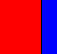

In [79]:
array_rgb = get_coverage_color_panel(54, 57,blocks, colors)
img_pil = Image.fromarray(array_rgb.astype("uint8"),"RGB")
img_pil

In [72]:
blocks

[Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=42, j=56, label='TCGCCGTTATTGGTA'),
 Block(K=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53), i=0, j=40, label='AATGGTTATCTCTAAAAAAGAGGTAAGATGCGTACTACTTA')]

In [73]:
array_rgb

array([[[1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        ...,
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235]],

       [[1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        ...,
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235]],

       [[1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        ...,
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235],
        [0.12156863, 0.46666667, 0.70588235]],

       ...,

       [[1.        , 0.49803922, 0.05490196],
        [1.        , 0.49803922, 0.05490196],
        [1.        , 0